In [8]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [8]:
import os
os.getcwd()

'c:\\GitHub\\2024DriveBase\\src\\main\\java\\frc\\robot\\utils'

['x', 'y', 'heading', 'dx', 'dy', 'dtheta']
[('x', 'dx'), ('y', 'dy'), ('heading', 'dtheta')]


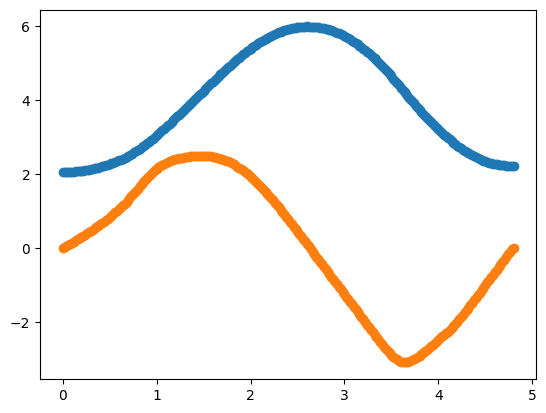

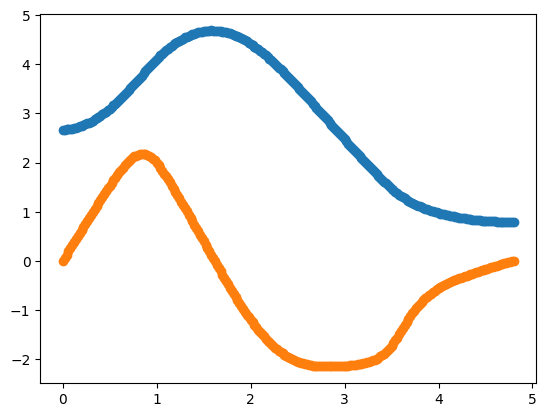

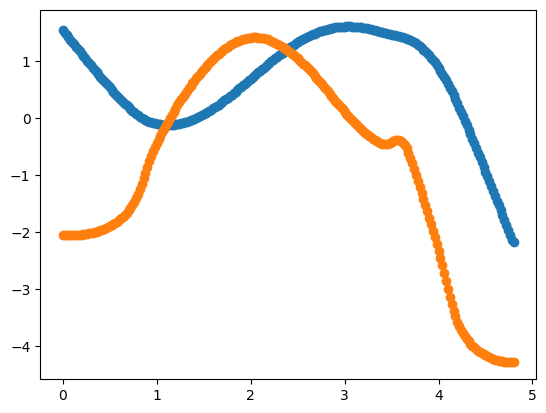

In [9]:
# GET DATA FROM CSV (generated from robot code) #
data = {}
headings = []
# lol plz tell me there's a better way to write that path...
with open('../../../../../../data/trajectory.csv' ,'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if i == 0:
            line = line.strip()
            line = line.split(',')
            for heading in line:
                headings.append(heading[1:-1]) # [1:-1] removes the quotes
                data[heading[1:-1]] = []
            continue
            
        line = line.strip()
        line = line.split(',')
        for i, value in enumerate(line):
            data[headings[i]].append(float(value[1:-1])) # [1:-1] removes the quotes

print(headings)
paired_headings = [(headings[i], headings[i+int(len(headings)/2)]) for i in range(0, int(len(headings) / 2))]
print(paired_headings)

dt = 0.02
data['time'] = [i * dt for i in range(len(data['x']))]

for pair in paired_headings:
    plt.plot(data['time'], data[pair[0]], 'o')
    plt.plot(data['time'], data[pair[1]], 'o')
    plt.show()

[('x', 'dx'), ('y', 'dy'), ('heading', 'dtheta')]


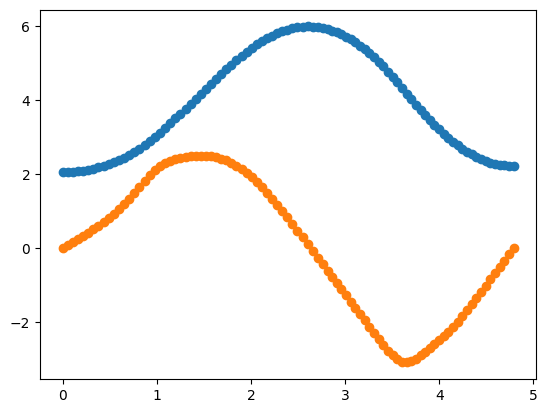

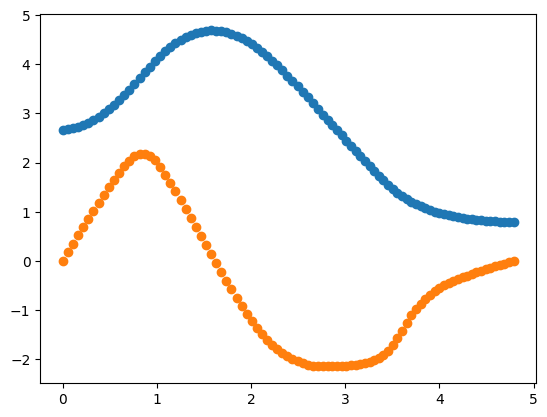

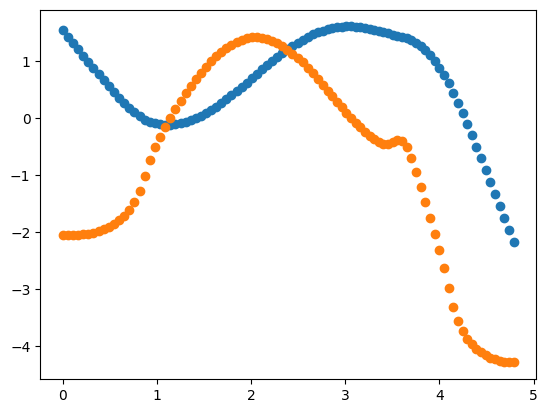

In [3]:
# GET DATA FROM .traj (generated from choreo) #
headings = ['x', 'y', 'heading', 'dx', 'dy', 'dtheta', 'time']
data = {heading: [] for heading in headings}

for point in pd.read_json('../../../../../../data/NewPath.traj')['samples']:
    data['x'].append(point['x'])
    data['y'].append(point['y'])
    data['heading'].append(point['heading'])
    data['dx'].append(point['velocityX'])
    data['dy'].append(point['velocityY'])
    data['dtheta'].append(point['angularVelocity'])
    data['time'].append(point['timestamp'])

paired_headings = [(headings[i], headings[i+int(len(headings)/2)]) for i in range(0, int(len(headings) / 2))]
print(paired_headings)

for pair in paired_headings:
    plt.plot(data['time'], data[pair[0]], 'o')
    plt.plot(data['time'], data[pair[1]], 'o')
    plt.show()

0.02


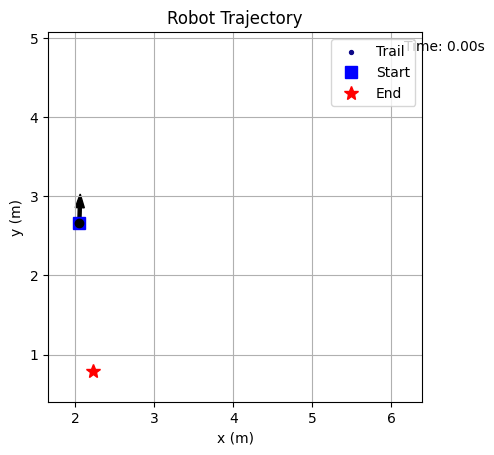

In [25]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.colors as mcolors

fig, ax = plt.subplots()

x_lim = [min(data['x']), max(data['x'])]
y_lim = [min(data['y']), max(data['y'])]

# adjust the x and y limits by a factor of 1.1 to make sure nothing is cut off
x_lim = [x_lim[0] - 0.1 * (x_lim[1] - x_lim[0]), x_lim[1] + 0.1 * (x_lim[1] - x_lim[0])]
y_lim = [y_lim[0] - 0.1 * (y_lim[1] - y_lim[0]), y_lim[1] + 0.1 * (y_lim[1] - y_lim[0])]

def format_axis(ax):
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_aspect('equal')
    ax.grid()
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title('Robot Trajectory')

# Create a colormap for the trail
# cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue", "green", "yellow", "red"])
cmap = plt.get_cmap('plasma')

# # Calculate the velocity
# data['vx'] = np.gradient(data['x'], dt)
# data['vy'] = np.gradient(data['y'], dt)
# data['v'] = np.sqrt(data['vx']**2 + data['vy']**2)

# # Normalize the velocity for the colormap
# v_norm = data['v'] / max(data['v'])

dt = data['time'][1] - data['time'][0]
print(dt)

# DRAWING THE ROBOT #
def draw_robot(x, y, heading, color='black', ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, y, 'o', color=color)
    arrow_scale = 0.03 * max(x_lim[1], y_lim[1])
    ax.arrow(x, y, arrow_scale * np.cos(heading), arrow_scale * np.sin(heading), color=color, width=arrow_scale/5)
    return ax

# ANIMATION #
def animate(i):
    ax.clear()
    format_axis(ax)

    # Only run every few frames ([:i+1:num_skipped]) to clearly show the separation between trail markers (used to visually show velocity)
    ax.scatter(data['x'][:i+1:2], data['y'][:i+1:2], c=range(0, i+1, 2), s=8, cmap=cmap, label='Trail')

    ax.plot(data['x'][0], data['y'][0], 'bs', markersize=8, label='Start')  # Blue square for start
    ax.plot(data['x'][len(data['x']) - 1], data['y'][len(data['x']) - 1], 'r*', markersize=10, label='End')  # Red star for end
    
    ax.legend()
    ax.annotate(f'Time: {i*dt:.2f}s', (0.95, 0.95), xycoords='axes fraction')  # Display the time
    
    draw_robot(data['x'][i], data['y'][i], data['heading'][i], ax=ax)


# draw_robot(data['x'][0], data['y'][0], data['heading'][0], ax=ax)
# plt.show()

speed = 1 # playback speed (1 = real time)
ani = FuncAnimation(fig, animate, frames=len(data['x']), interval=1/speed * (dt * 1000))

# Display the animation in the Jupyter notebook
HTML(ani.to_html5_video())